In [1]:
import numpy as np 
import pickle 
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [85]:
image_size=tuple((256,256))
batch_size=32
init_lr=1e-3
epochs=25
directory_root_train= "New Plant Diseases Dataset(Augmented)/train"
directory_root_test="New Plant Diseases Dataset(Augmented)/valid"
width=256
height=256
chanels=3

In [9]:
def convert_image_to_array(image_path):
    try :
        image = cv2.imread(image_path)
        if image is not None :
            image=cv2.resize(image,image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e :
        print(f"Error :{e}")
        return None 

In [46]:
def read_file_image(directory_root):
    image_list, label_list=[],[]
    try :
        plant_folder = listdir(directory_root)   
        for plant_disease_folder in plant_folder:
            print (f"[INFO] Processing {plant_disease_folder}...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}")
        
            for image in plant_disease_image_list[:200]:
                image_directory=f"{directory_root}/{plant_disease_folder}/{image}"
                
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(cv2.imread(image_directory))
                    label_list.append(plant_disease_folder)
    except Exception as e:
        print (f"Error :{e}")
        
    return image_list,label_list

In [57]:
image,label=read_file_image(directory_root_train)

[INFO] Processing Apple___Apple_scab...
[INFO] Processing Apple___Black_rot...
[INFO] Processing Apple___Cedar_apple_rust...
[INFO] Processing Apple___healthy...
[INFO] Processing Blueberry___healthy...
[INFO] Processing Cherry_(including_sour)___healthy...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot...
[INFO] Processing Corn_(maize)___Common_rust_...
[INFO] Processing Corn_(maize)___healthy...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight...
[INFO] Processing Grape___Black_rot...
[INFO] Processing Grape___Esca_(Black_Measles)...
[INFO] Processing Grape___healthy...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot)...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening)...
[INFO] Processing Peach___Bacterial_spot...
[INFO] Processing Peach___healthy...
[INFO] Processing Pepper,_bell___Bacterial_spot...
[INFO] Processing Pepper,_bell___healthy...
[INFO] Processing Potato___Ear

Total number of images : 7600
Total number of lables : 7600
Image type : <class 'numpy.ndarray'>
Image shape : (256, 256, 3)


Text(0.5, 1.0, 'Apple___Black_rot')

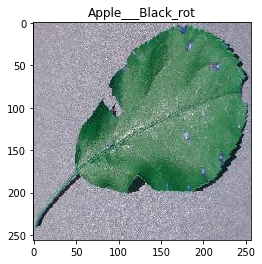

In [61]:
print(f"Total number of images : {len(image)}")
print(f"Total number of lables : {len(label)}")
print(f"Image type : {type(image[0])}")
print(f"Image shape : {image[0].shape}")
plt.imshow(image[256])
plt.title(label[256])

In [62]:
label_binarizer=LabelBinarizer()
image_labels= label_binarizer.fit_transform(label)

In [65]:
print(f"Number of classes : {len(label_binarizer.classes_)}")
print(f"Classes : {label_binarizer.classes_}")
print(f"Binarized labels : {image_labels}")
print(f"Print total number of labels : {len(image_labels)}")

Number of classes : 38
Classes : ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tom

In [ ]:
image=np.array(image,dtype=np.float16)/255

In [81]:
print("[INFO] Spliting data to train ,test")
x_train,x_test,y_train,y_test=train_test_split(image,image_labels,test_size=0.20,random_state=42)

[INFO] Spliting data to train ,test


In [84]:
train = torch.utils.data.TensorDataset(torch.from_numpy(x_train),
                                       torch.from_numpy(y_train))
train_loader= torch.utils.data.DataLoader(train,batch_size=batch_size,
                                          shuffle=True,num_workers=2)

test = torch.utils.data.TensorDataset(torch.from_numpy(x_test),
                                      torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,
                                         shuffle=True,num_workers=2)

In [93]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #layer 1
        self.conv1=nn.Conv2d(in_channels=chanels,out_channels=32
                             ,kernel_size=3,padding=1)
        self.conv1_bn=nn.BatchNorm2d(num_features=32)
        self.pooling1=nn.MaxPool2d(3,stride=3)
        self.drop1=nn.Dropout(0.25)
        #layer 2
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,
                            kernel_size=3,padding=1)
        self.conv2_bn=nn.BatchNorm2d(num_features=64)
        #layer3
        self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,
                            padding=1)
        self.conv3_bn=nn.BatchNorm2d(num_features=64)
        self.pooling3=nn.MaxPool2d(2,stride=2)
        self.drop3=nn.Dropout(0.25)
        #layer4
        self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,
                            padding=1)
        self.conv4_bn=nn.BatchNorm2d(num_features=128)
        #layer5
        self.conv5=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,
                            padding=1)
        self.conv5_bn=nn.BatchNorm2d(num_features=128)
        self.pooling5=nn.MaxPool2d(2,stride=2)
        self.drop5=nn.Dropout(0.25)
        #fully_conceted-layers
        self.fc1=nn.Linear(128*21*21,1024)
        self.fc1_bn=nn.BatchNorm1d(num_features=1024)
        self.drop_fc1=nn.Dropout(0.5)
        self.fc2=nn.Linear(1024,len(label_binarizer.classes_))
        
    def forward(self,x):
        #bloc 1
        x = self.drop1(self.pooling1(self.conv1_bn(F.relu(self.conv1(x)))))
        #bloc 2
        x = self.conv2_bn(F.relu(self.conv2(x)))
        #bloc 3
        x = self.drop3(self.pooling3(self.conv3_bn(F.relu(self.conv3(x)))))
        #bloc 4
        x = self.conv4_bn(F.relu(self.conv4(x)))
        #bloc 5
        x = self.drop5(self.pooling5(self.conv5_bn(F.relu(self.conv5(x)))))
        #bloc 6
        x=x.view(-1,128*21*21)
        x= self.drop_fc1(self.fc1_bn(F.relu(self.fc1(x))))
        x= F.softmax(self.fc2(x))
        return x

In [94]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), 

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=init_lr,weight_decay=init_lr/epochs)

In [98]:
training_loss=[]
test_loss=[]
training_acc=[]
test_acc=[]
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()  
    training_loss.append(running_loss/(i+1))
    #train_accuracy
    class_correct = list(0. for i in range(len(label_binarizer.classes_)))
    class_total = list(0. for i in range(len(label_binarizer.classes_)))
    total=0
    correct=0
    net.eval()
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    training_acc.append(100 * correct / total)
    
    #validation loss
    running_loss = 0.0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test_loader, 0):
            
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
    test_loss.append(running_loss/(i+1))
        
    #test_accuracy
    class_correct = list(0. for i in range(len(label_binarizer.classes_)))
    class_total = list(0. for i in range(len(label_binarizer.classes_)))
    total=0
    correct=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc.append(100 * correct / total)
    print(f"Test acc : {test_acc}")
    print(f"Train acc : {training_acc}")
        
print('Finished Training')

RuntimeError: Given groups=1, weight of size 32 3 3 3, expected input[32, 256, 256, 3] to have 3 channels, but got 256 channels instead